In [1]:
import os
import rasterio as rio
import numpy as np
import shapely
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as riox
import rasterio as rio
import xarray as xr
import netCDF4
from osgeo import gdal
import pandas as pd
from datetime import datetime
import dask.array
from scipy.stats import linregress

In [2]:
# define folder and file paths
folder_HMA = os.path.join('C:',os.sep,'Users','lzell','OneDrive - Colostate','Desktop',"HMA2")
folder_glaciers = os.path.join(folder_HMA, 'Glacier Products')
folder_datasets = os.path.join(folder_HMA, 'Datasets')
fp_rgi = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', "Final Products", 'AOI_full_rgi.shp')
fp_regions = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', "Final Products", 'subregion_boundaries.shp')

In [3]:
# open the rgi gdf, regions gdf
rgi_gdf = gpd.read_file(fp_rgi).to_crs("ESRI:102025")
regions_gdf = gpd.read_file(fp_regions).to_crs("ESRI:102025")
print(regions_gdf.crs)
print(rgi_gdf.crs)

ESRI:102025
ESRI:102025


In [ ]:
# process each glacier
c=0
for idx, row in rgi_gdf.iterrows():
    c+=1
    # if c>1: continue

    # grab glacier regions, rgiid, area
    rgi_id = row['rgi_id']
    o1region = row['o1region']
    o2region = row['o2region']
    
    # if o1region!='15': continue
    # if rgi_id != "RGI2000-v7.0-G-15-06758": continue
    
    # print progress
    if c%10==0: print(c, "of", len(rgi_gdf), rgi_id)
    
    # open glacier mask, debris mask
    # path_open = os.path.join(folder_glaciers, rgi_id, 'Base Products', 'glacier_mask.tif')
    # xr_gmask = riox.open_rasterio(path_open, masked=False).squeeze(drop=True)
    # xr_gmask = xr_gmask.where(xr_gmask==1)
    path_open = os.path.join(folder_glaciers, rgi_id, 'Base Products', 'debris_mask.tif')
    xr_dmask = riox.open_rasterio(path_open, masked=False).squeeze(drop=True)
    xr_dmask = xr_dmask.where(xr_dmask==1)
    
    # open dhdt, distances
    path_open = os.path.join(folder_glaciers, rgi_id, 'Base Products', 'glacier_dhdt.tif')
    xr_dhdt = riox.open_rasterio(path_open, masked=False).squeeze(drop=True)
    xr_dhdt = xr_dhdt.where(xr_dmask==1,np.nan)
    xr_dhdt['band'] = list(xr_dhdt.attrs['long_name'])
    
    path_open = os.path.join(folder_glaciers, rgi_id, 'Base Products', 'debris_distances.tif')
    xr_distances = riox.open_rasterio(path_open, masked=False).squeeze(drop=True)
    
    # open glacier branch product
    path_open = os.path.join(folder_glaciers, rgi_id, 'Base Products', 'debris_glacier_branches.tif')
    xr_branches = riox.open_rasterio(path_open, masked=False).squeeze(drop=True)
    
    # count number of branches
    branch_ns = np.unique(xr_branches)
    branch_ns = branch_ns[~np.isnan(branch_ns)].astype(int)
    
    # for each branch, calculate dhdt changes with distance
    all_branch_dfs = []
    for n in branch_ns:
        
        # subset elevation and distances to this branch
        xr_distances_n = xr_distances.where(xr_branches==n, np.nan)
        xr_dhdt_n = xr_dhdt.where(xr_branches==n, np.nan)
        
        # calculate max, min distance
        ds = np.unique(xr_distances_n)
        ds = np.sort(ds[~np.isnan(ds)])
#         max_distance = np.nanmax(ds)
#         min_distance = np.nanmin(ds)
#         d_bands = np.arange(round(min_distance,-2), round(max_distance,-2)+1, 100)
        
        # make df that holds dhdt in each timestep at each distance band
        dhdt_branch = [] 
        for d in ds:
            
            # distance bands are extended up and down glacier to smooth them out
            dhdt_band = xr_dhdt_n.where( (xr_distances_n>=(d-250)) & (xr_distances_n<=(d+250)), np.nan)
            dhdt_means = dhdt_band.mean(dim=('x','y')) \
                            .to_dataframe(str(d)).drop('spatial_ref',axis=1).T
            dhdt_branch.append(dhdt_means)

        # combine df
        dhdt_branch = pd.concat(dhdt_branch).add_prefix(f"{n}_")
        
        # add to all_branch_dfs
        all_branch_dfs.append(dhdt_branch)
        
    # concat all dfs together at the end
    all_branch_dfs = pd.concat(all_branch_dfs).reset_index().rename({'index':'distance'}, axis=1)
    all_branch_dfs['distance'] = [int(float(d)) for d in all_branch_dfs['distance'] ]
    
    # save to csv
    out_path = os.path.join(folder_glaciers, rgi_id, 'Base Products', 'glacier_dhdt_distances.csv')
    all_branch_dfs.to_csv(out_path, index=False)
        # break
    # break
print("All done!")

10 of 769 RGI2000-v7.0-G-13-02562
20 of 769 RGI2000-v7.0-G-13-05693
30 of 769 RGI2000-v7.0-G-13-06682
40 of 769 RGI2000-v7.0-G-13-14221
50 of 769 RGI2000-v7.0-G-13-14611
60 of 769 RGI2000-v7.0-G-13-15404
70 of 769 RGI2000-v7.0-G-13-16527
80 of 769 RGI2000-v7.0-G-13-17029
90 of 769 RGI2000-v7.0-G-13-19142
100 of 769 RGI2000-v7.0-G-13-24023
110 of 769 RGI2000-v7.0-G-13-27852
120 of 769 RGI2000-v7.0-G-13-28825
130 of 769 RGI2000-v7.0-G-13-30163
140 of 769 RGI2000-v7.0-G-13-42918
150 of 769 RGI2000-v7.0-G-13-48300
160 of 769 RGI2000-v7.0-G-13-71337
170 of 769 RGI2000-v7.0-G-13-71687
180 of 769 RGI2000-v7.0-G-13-73276
190 of 769 RGI2000-v7.0-G-13-74920
200 of 769 RGI2000-v7.0-G-14-01890
210 of 769 RGI2000-v7.0-G-14-02431
220 of 769 RGI2000-v7.0-G-14-05926
230 of 769 RGI2000-v7.0-G-14-07200
240 of 769 RGI2000-v7.0-G-14-07878
250 of 769 RGI2000-v7.0-G-14-08548
260 of 769 RGI2000-v7.0-G-14-10950
270 of 769 RGI2000-v7.0-G-14-11332
280 of 769 RGI2000-v7.0-G-14-11697
290 of 769 RGI2000-v7.0-G-14-

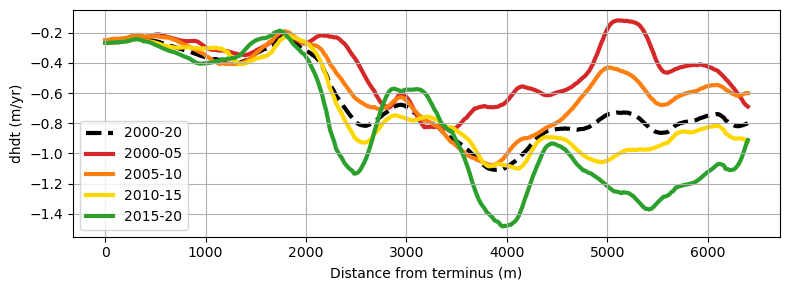

In [125]:
fig,axs = plt.subplots(figsize=(8,3))

for i,n in enumerate(branch_ns):
    axs.plot( all_branch_dfs['distance'], all_branch_dfs[f'{n}_2000-01-01_2020-01-01'], zorder=1,
                 c='black', linestyle='dashed', linewidth=3, label="2000-20")
    axs.plot( all_branch_dfs['distance'], all_branch_dfs[f'{n}_2000-01-01_2005-01-01'], zorder=1,
                 c='tab:red', linestyle='solid', linewidth=3, label="2000-05")
    axs.plot( all_branch_dfs['distance'], all_branch_dfs[f'{n}_2005-01-01_2010-01-01'], zorder=1,
                 c='tab:orange', linestyle='solid', linewidth=3, label="2005-10")
    axs.plot( all_branch_dfs['distance'], all_branch_dfs[f'{n}_2010-01-01_2015-01-01'], zorder=1,
                 c='gold', linestyle='solid', linewidth=3, label="2010-15")
    axs.plot( all_branch_dfs['distance'], all_branch_dfs[f'{n}_2015-01-01_2020-01-01'], zorder=1,
                 c='tab:green', linestyle='solid', linewidth=3, label="2015-20")
    
axs.legend()
axs.set_xlabel("Distance from terminus (m)")
axs.set_ylabel("dhdt (m/yr)")
axs.grid(zorder=1)
plt.tight_layout()

In [113]:
all_branch_dfs

band,distance,1_2000-01-01_2005-01-01,1_2000-01-01_2010-01-01,1_2000-01-01_2020-01-01,1_2005-01-01_2010-01-01,1_2010-01-01_2015-01-01,1_2010-01-01_2020-01-01,1_2015-01-01_2020-01-01
0,0,-0.266965,-0.266973,-0.266975,-0.248003,-0.266976,-0.266977,-0.266978
1,20,-0.268150,-0.268157,-0.268158,-0.248900,-0.268158,-0.268159,-0.268160
2,40,-0.267820,-0.267826,-0.267826,-0.247000,-0.267824,-0.267825,-0.267825
3,60,-0.263478,-0.263484,-0.263482,-0.241922,-0.263482,-0.263481,-0.263480
4,80,-0.263966,-0.263971,-0.263969,-0.241643,-0.263968,-0.263967,-0.263967
...,...,...,...,...,...,...,...,...
316,6320,-0.624595,-0.658179,-0.818297,-0.614777,-0.900495,-0.978416,-1.056337
317,6340,-0.641660,-0.665946,-0.814689,-0.612488,-0.900614,-0.963432,-1.026249
318,6360,-0.664139,-0.674352,-0.810720,-0.605325,-0.907024,-0.947088,-0.987152
319,6380,-0.679185,-0.679093,-0.804998,-0.599510,-0.916078,-0.930903,-0.945728
